### Load data set with features

In [1]:
from create_df import read_df
df, dfc, all_homes, appliance_min, national_average = read_df()

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
run all_functions.py

In [4]:
run features.py

In [5]:
import json

In [6]:
len(feature_map['15 min AMI']), len(feature_map['All']), len(feature_map['Monthly+Static']), len(feature_map['Monthly'])

(40, 43, 18, 15)

#### First round of CV, finding optimal features maximising median accuracy

In [7]:
out_mean, optimal_dict_mean = find_optimal_features(df, dfc, all_homes, appliance_min, national_average, 
                                                        ["hvac","light","fridge","dr","wm","dw"],
                                                        {"Static":feature_map["Static"],
                                                        'Monthly':feature_map['Monthly']},
                          NUM_NEIGHBOURS_MAX=7, F_length_max=7, metric="mean",
                          train_outlier=True, test_outlier=False, outlier_features=None, outlier_fraction=0.1,
                     print_steps=True)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
hvac
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
********************
Monthly
********************
include: aggregate_5 -> feature_subset: ['aggregate_5']. Accuracy: 77.7576037951
include: aggregate_7 -> feature_subset: ['aggregate_5', 'aggregate_7']. Accuracy: 78.6794696401
include: aggregate_9 -> feature_subset: ['aggregate_5', 'aggregate_7', 'aggregate_9']. Accuracy: 80.3322403758
include: aggregate_12 -> feature_subset: ['aggregate_5', 'aggregate_7', 'aggregate_9', 'aggregate_12']. Accuracy: 80.1110824723
include: aggregate_10 -> feature_subset: ['aggregate_5', 'aggregate_7', 'aggregate_9', 'aggregate_12', 'aggregate_10']. Accuracy: 79.9786206651
include: difference_min_max -> feature_subset: ['aggregate_5', 'aggregate_7', 'aggregate_9', 'aggregate_12', 'aggregate_10', 'difference_min_max']. Accuracy: 80.0580878598
include: aggregate_8 -> feature_subset: ['aggregate_5', 'aggregate_7', 'aggregate_9', 'aggregate_12', 'aggregate_10', 'difference_m

In [11]:
optimal_all_mean = json.load(open("without-test-optimal_dict.json","r"))

s = {}
for appliance in ['fridge','dw','dr','hvac','light','wm']:
    print appliance
    s[appliance] = {}
    for feature in ["All",'Monthly','Static']:
        s[appliance][feature] = {}
        if feature=="All":
            k=optimal_all_mean[appliance]['All']['k']
            f=optimal_all_mean[appliance]['All']['f']
            
        else:
            k=optimal_dict_mean[appliance][feature]['k']
            f=optimal_dict_mean[appliance][feature]['f']
            
            
        temp = create_predictions(df, dfc, all_homes, appliance_min,
                                          national_average, appliance=appliance, 
                                          feature=f,
                                          NUM_NEIGHBOURS=k, train_outlier=True, test_outlier=False,
                                          outlier_features=None, outlier_fraction=0.1)


        errors = {}
        if appliance =="hvac":
            start_month, end_month = 5, 11
        else:
            start_month, end_month = 1, 13
        for i in range(start_month, end_month):
            errors[i] = percentage_error(temp[i]["gt"], temp[i]["pred"])
        error_df = pd.DataFrame(errors)
        accur_df = 100-error_df
        accur_df[accur_df<0]=0
        tdf = accur_df
        if appliance =="hvac":
            for home in [624, 1953, 6636, 6836, 7769, 9922]:
                tdf.loc[home, 5]=np.NaN
                tdf.loc[home, 10]=np.NaN

        s[appliance][feature] = tdf.dropna().mean().mean()
            

fridge
dw
dr
hvac
light
wm


In [12]:
appliance_name_mapping = {"dr": "Dryer", "wm": "Washing\nmachine",
                          "fridge":"Fridge","light":"Lights",
                          "hvac":"HVAC","dw":"Dish\nwasher"}

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
sen = pd.DataFrame(s)

In [15]:
sen

,dr,dw,fridge,hvac,light,wm
All,47.722867,44.929176,81.121122,82.183540,49.873465,65.535383
Monthly,44.068747,43.463552,77.740660,82.159865,47.066094,64.363110
Static,43.113456,39.257169,75.182587,77.885608,48.235812,60.045676


In [16]:
sen = sen.rename(columns=appliance_name_mapping).T

In [17]:
from common_functions import latexify, format_axes
latexify()

tableau20blind =  [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
  
# Rescale to values between 0 and 1
for i in range(len(tableau20blind)):  
    r, g, b = tableau20blind[i]  
    tableau20blind[i] = (r / 255., g / 255., b / 255.)

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


/Users/nipunbatra/anaconda/lib/python2.7/site-packages/pandas/tools/plotting.py:856: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


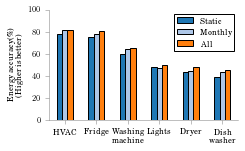

In [18]:
sen[['Static','Monthly','All']].ix[['HVAC','Fridge','Washing\nmachine',
                                    'Lights','Dryer','Dish\nwasher']].plot(kind="bar",rot=0, colors=tableau20blind)
plt.ylim((0, 100));
plt.ylabel("Energy accuracy(\%)\n(Higher is better)");
plt.tight_layout()
format_axes(plt.gca())
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/results/features_sensitivity.pdf",bbox_inches="tight")
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/results/features_sensitivity.png",bbox_inches="tight")